# DBSCAN. Практическая работа

## Цель практической работы

Научиться строить модели кластеризации с помощью метода DBSCAN.

## Что входит в работу


- Загрузите данные и проведите разведочный анализ.
- Предположите оптимальное количество кластеров.
- Постройте модель кластеризации DBSCAN.
- Определите оптимальное количество и структуру кластеров.
- Интерпретируйте полученные результаты.

## Что оценивается 

1. Выполнены все задания.
2. Сделаны выводы по результатам разведочного анализа данных.
3. Объяснены выбранные гиперпараметры модели кластеризации.
4. Сделаны выводы о количестве и структуре кластеров.
5. Сделаны выводы по результатам кластеризации.

# Задача

Имеется некоторый набор данных `gt_2015.csv` о производительности и других параметрах ветряных электростанций:
* AT — температура окружающей среды.
* PT — давление окружающей среды.
* AH — влажность окружающей среды. 
* AFDP — перепад давления на воздушном фильтре. 
* GTEP — давление на выходе из газовой турбины. 
* TIT — температура на входе в турбину.
* TAT — температура на выходе из турбины. 
* TEY — энергоотдача турбины.
* CDP — давление нагнетания компрессора.
* CO — выбросы угарного газа. 
* NOX — выбросы оксидов азота.

Решите задачу кластеризации электростанций для дальнейшего совместного управления схожими электростанциями.

# Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других свойствах данных, которые вы обнаружите.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv('gt_2015.csv')

In [3]:
df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491,113.250
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684,112.020
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335,88.147
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972,87.078
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833,82.515


In [4]:
# очень недобные названия
col_names = dict()
for col in df.columns:
    col_names[col] = col.lower()[3:] if 'mnt' in col.lower() else (col.lower()[3:] if 'num' in col.lower() else  col.lower())
df = df.rename(columns=col_names)

In [5]:
for col in df.columns:

    res = stats.shapiro(df[col])
#     print(res[1] > 0.05)
    print(col,' - not normal dist' if res.pvalue <= 0.05  else '- normal dist')

at  - not normal dist
ap  - not normal dist
ah  - not normal dist
afdp  - not normal dist
gtep  - not normal dist
tit  - not normal dist
tat  - not normal dist
tey  - not normal dist
cdp  - not normal dist
co  - not normal dist
nox  - not normal dist


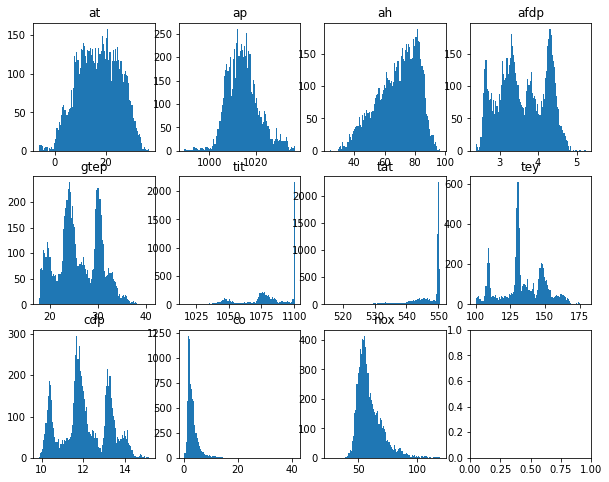

In [6]:
ax = plt.subplots(3, (len(df.columns) // 3 + 1), figsize=(10,8), )[1]
i = 0
k = 0
counter = 0
for col in df.columns:
    if counter == 4:
        i +=1
        counter = 0
        k = 0
    ax[i][k].hist(df[col], bins=100)
    ax[i][k].set_title(f'{col}')#, rotation=30)
    k += 1
    counter += 1


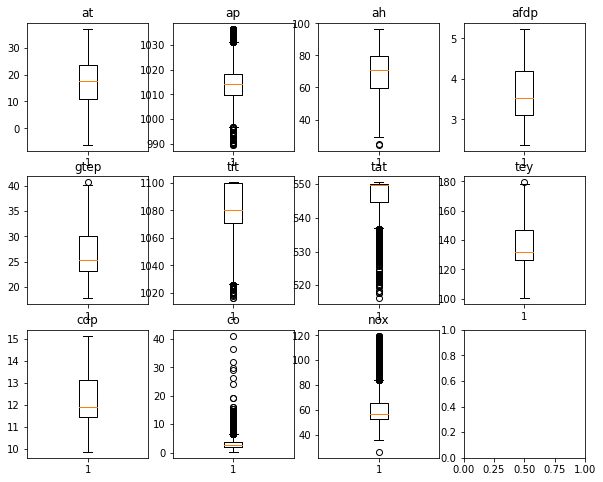

In [7]:
ax = plt.subplots(3, (len(df.columns) // 3 + 1), figsize=(10,8), )[1]
i = 0
k = 0
counter = 0
for col in df.columns:
    if  col == 'dt_customer':
        continue
    if counter == 4:
        i +=1
        counter = 0
        k = 0
    ax[i][k].boxplot(df[col])
    ax[i][k].set_title(f'{col}')#, rotation=30)
    k += 1
    counter += 1

In [8]:
# выбросов немало, кажется
# перетащим пару полезных функций из прошлых модулей

In [5]:
def calculate_iqr_boundaries(series):
    q25 = series.quantile(0.25)
    q75 = series.quantile(0.75)
    iqr = q75 - q25

    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

In [6]:
def bounds_f(df):
    bounds = []
    bounds_d = dict()
    for col in df.columns:
#         if col == 'gender':
#             continue
#         iter_name = f'{col}'
        bounds_d[col] = calculate_iqr_boundaries(df[col])
#         bounds.append(calculate_iqr_boundaries(df[col]))
#     for i in range(len(df.columns)):
#         if x_train.columns[i] == 'gender':
#             continue
#         bounds_d[df.columns[i]] = bounds[i]
    return bounds_d


In [8]:
possible_cl_count_leads = {
    'gtep': 'давление на выходе из газовой турбины',
    'cdp': 'давление нагнетания компрессора',
    'tey': 'энергоотдача турбины',
    'afdp': 'перепад давления на воздушном фильтре',
}

In [9]:
df[possible_cl_count_leads.keys()]

,gtep,cdp,tey,afdp
0,20.116,10.799,116.27,2.5304
1,18.584,10.347,109.18,2.3937
2,22.264,11.256,125.88,2.7789
3,23.358,11.702,132.21,2.8170
4,23.483,11.737,133.58,2.8377
...,...,...,...,...
7379,19.087,10.411,109.08,3.1661
7380,19.016,10.344,108.79,3.1923
7381,18.857,10.462,107.81,3.3128
7382,23.563,11.771,131.41,3.9831


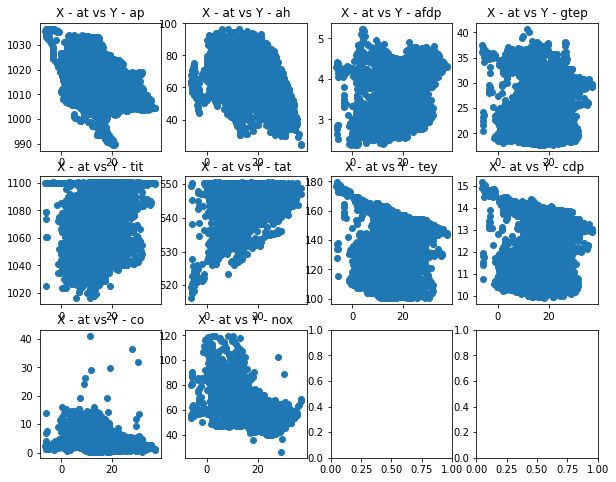

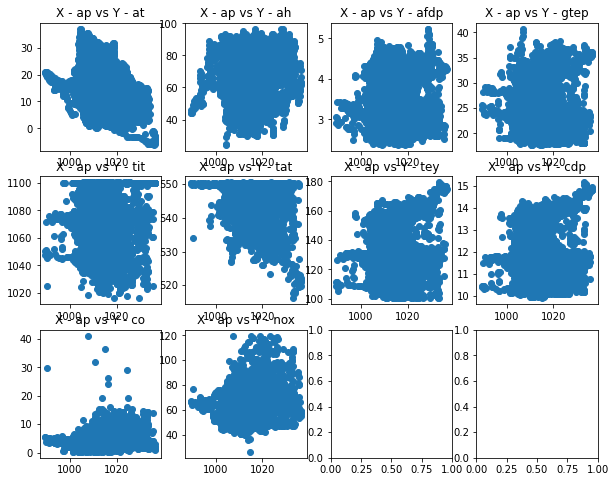

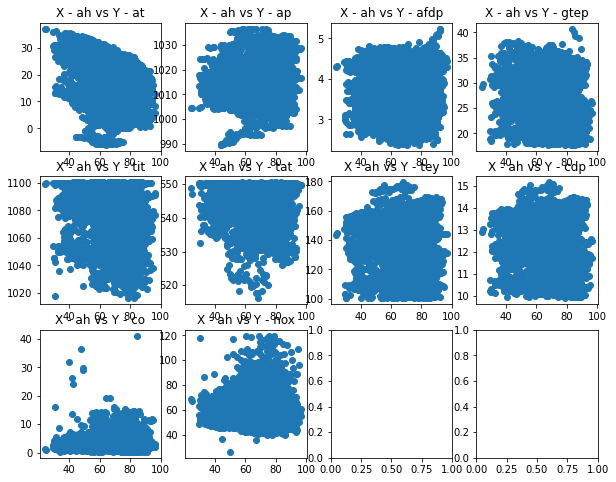

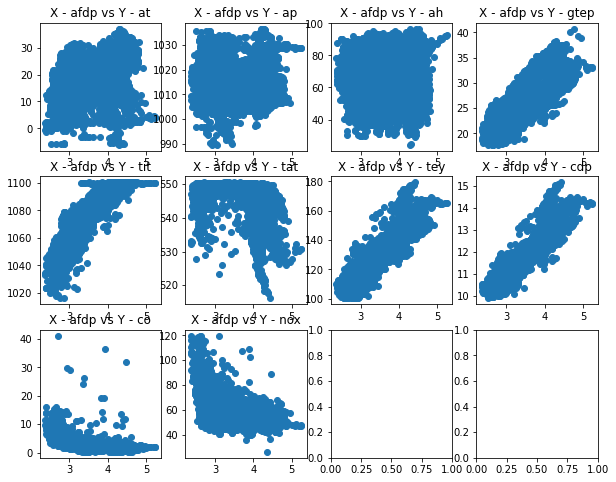

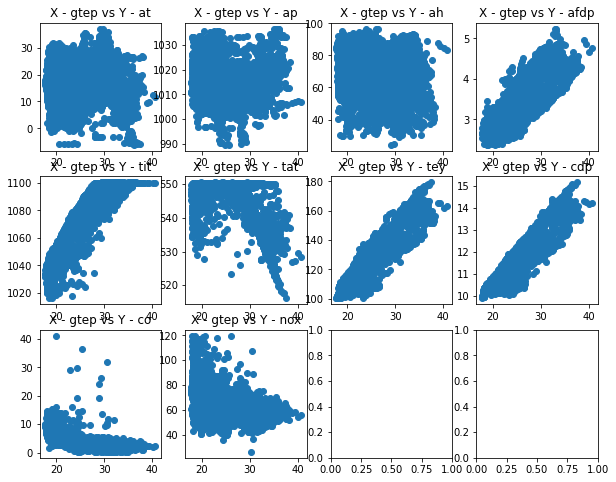

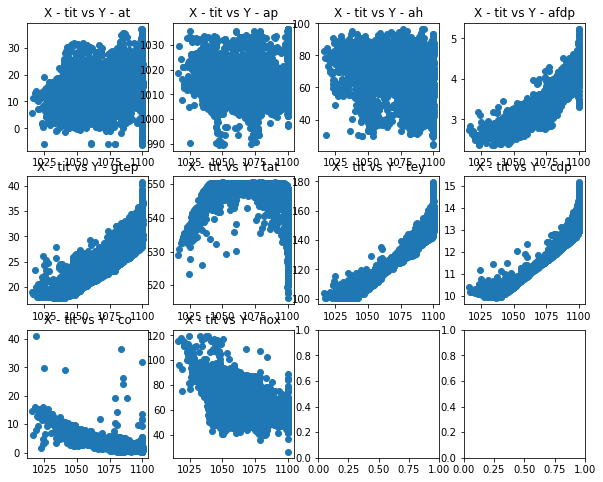

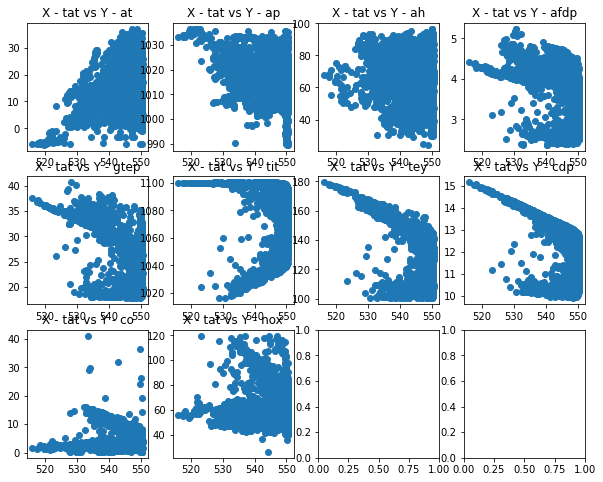

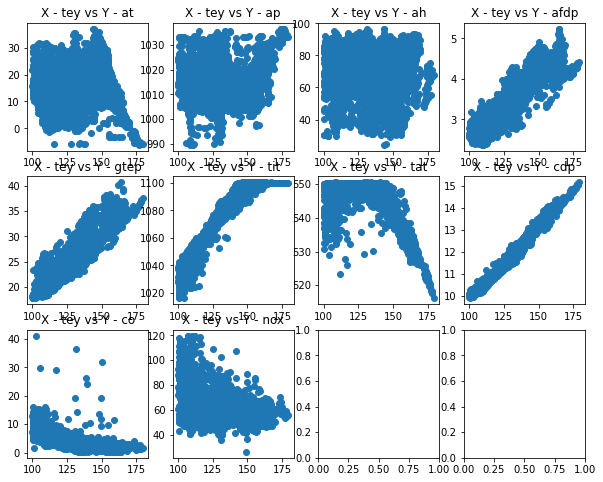

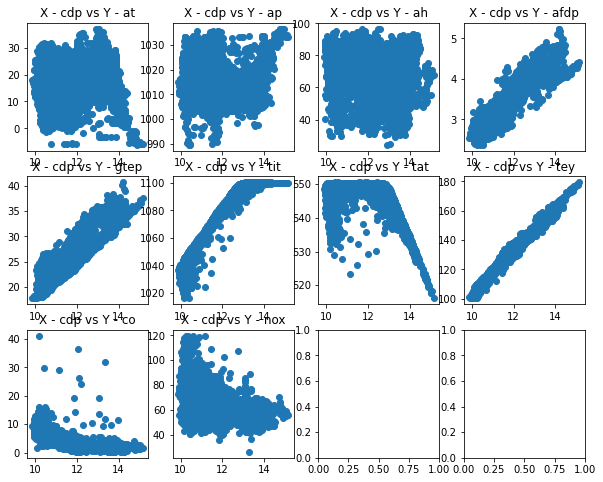

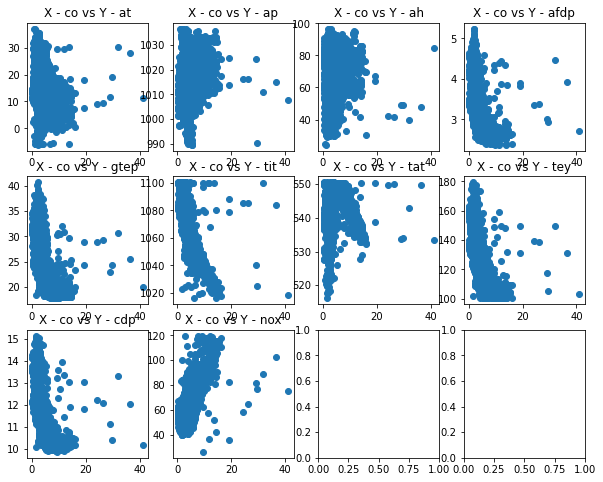

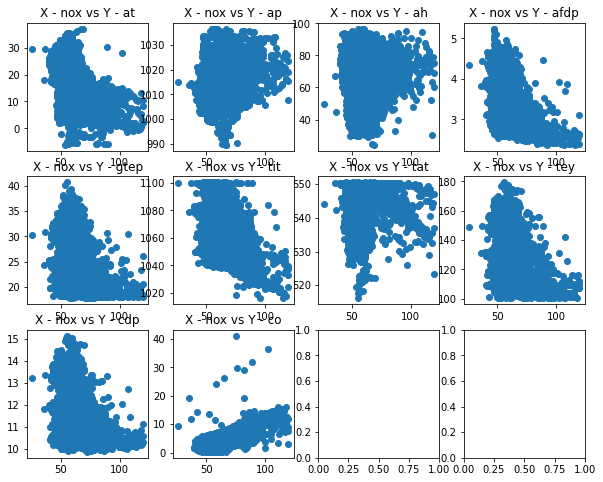

In [13]:
for col_main in df.columns:
    num_cols = []
    for col in df.columns:
        if col == col_main:
            continue
        else:
            num_cols.append(col)
            
    ax = plt.subplots(3, (len(df.columns) // 3 + 1), figsize=(10,8), )[1]
    i = 0
    k = 0
    counter = 0
    for col in num_cols:
        if  col == 'dt_customer':
            continue
        if counter == 4:
            i +=1
            counter = 0
            k = 0
        ax[i][k].scatter(df[col_main], df[col])
        ax[i][k].set_title(f'X - {col_main} vs Y - {col}')#, rotation=30)
        k += 1
        counter += 1

<AxesSubplot:>

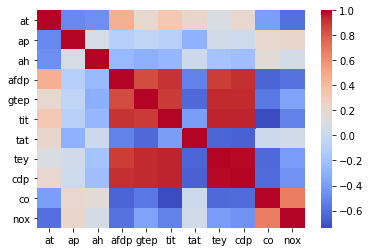

In [10]:
sns.heatmap(df.corr(), cmap='coolwarm')

# Задание 2

Предположите по результатам разведочного анализа данных, какие группы электростанций существуют, чем они отличаются, каково их количество.

In [15]:
possible_cl_count_leads

{'gtep': 'давление на выходе из газовой турбины',
 'cdp': 'давление нагнетания компрессора',
 'tey': 'энергоотдача турбины',
 'afdp': 'перепад давления на воздушном фильтре'}

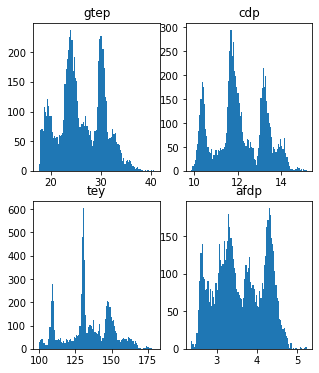

In [16]:
ax = plt.subplots(2, 2, figsize=(5,6), )[1]
i = 0
k = 0
counter = 0
for col in df[possible_cl_count_leads.keys()].columns:
    if counter == 2:
        i +=1
        counter = 0
        k = 0
    ax[i][k].hist(df[col], bins=100)
    ax[i][k].set_title(f'{col}')#, rotation=30)
    k += 1
    counter += 1


In [17]:
# ну я могу в принципе, думаю, понять связь между давлением компрессора и давлением на выходе из 
# турбины - опять же, это подтверждается графиками
# предположим, турбины работают в трех режимах основных "усердия"
# отсюда же связь с энергоотдачей
# пока напрашивается 3 кластера

# правда 4 отчетливых "спайка" в колонке перепадов давления как то не особо встраиваются в эту теорию - думаю,
# возьмем, как вариант еще 4 кластера - думаю, мы можем себе позволить отработать 2 версии\

# Задание 3

Постройте модель кластеризации DBSCAN. Подберите оптимальные гиперпараметры, руководствуясь как результатами сеточного поиска, так и результатами анализа данных в предыдущих заданиях.

In [130]:
# нуу... забегая вперед, можно сазать, что данные не захотели делиться ни на 3, ни на 4 кластера)

In [107]:
# ячейки ниже - финальный вариант - до этого было много гридсерчей и переборов 'вручную' с разной степенью гранульности:)
# в итоге:
# грид дал самый адекватный вариант разбивки, как мне кажется - т.к. 'ручной' перебор давал либо вариант с одним 
# большим кластером и 20 выбросов, либо 2к+ классов по 2-4 объекта
# а грид дал 68 классов и не по 2 экземпляра в каждом, а какое то вменяемое количество, и огромный класс-выброс - ну, я 
# подумал, значит, там закономерностей не нашлось:)
# еще хотел от безысходности через tsne сделать, прогнать там на уменьшенной размерности и прилепить ярлыки к исходному сету - но 
# до такой порнографии не дошло - кстати - а это вообще "законно" было бы?) в теории же отношения внустри 
# кластеров должны сохраниться, но я не уверен, что это сработало бы, учитывая, что модель не могла нащупать 
# кластеры как таковые
# ......
# кластеры продолжили не хотеть делиться, любопытства ради все же попоробовал уменьшить размерность и потом 
# уже поделить - совсем плохой вариант

In [7]:
# для начала отскалируем 
scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [8]:
model = DBSCAN(eps=0.7, min_samples=10)
model.fit(df_scaled)

DBSCAN(eps=0.7, min_samples=10)

In [9]:
scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [10]:
df_scaled['labels'] = 0

In [11]:
df_no_outliers = df.copy()
bounds = bounds_f(df_no_outliers)

for col in df_no_outliers:
    df_no_outliers[col] = df_no_outliers[col].apply(lambda x: bounds[col][0] if x < bounds[col][0] else ( bounds[col][1] if x > bounds[col][1] else x))

    
# для начала отскалируем 
scaler = MinMaxScaler()

df_no_outliers_scaled = pd.DataFrame(scaler.fit_transform(df_no_outliers), columns=df_no_outliers.columns)

df_no_outliers_scaled['labels'] = 0

In [12]:
1+4

5

In [28]:
epss = np.arange(0.1, 1.1, 0.7)
min_samples = np.arange(2, 5, 3)
scores = dict()
counter = 0
for eps in epss:
    for ms in min_samples:
        score_int = dict()
        model2 = DBSCAN(eps=eps, min_samples=ms)
        model2.fit(df_no_outliers_scaled)
        df_no_outliers_scaled['labels'] = model2.labels_
        sil_score = silhouette_score(df_no_outliers_scaled, df_no_outliers_scaled['labels'])
        score_int['current'] = {'score': sil_score,
                                'eps': eps,
                                'min_samples': ms,
                                'clusters': len(df_no_outliers_scaled['labels'].value_counts()),
                               }
#         if len(scores.keys()) > 0:
#             if sil_score < scores[f'model_{counter - 1}']['score']:
#                 continue
        scores[f'model_{counter}'] = score_int['current']
        
        counter += 1
        
        
        

        

In [29]:
scores

{'model_0': {'score': 0.6629711114916067,
  'eps': 0.1,
  'min_samples': 2,
  'clusters': 580},
 'model_1': {'score': 0.6629711114917621,
  'eps': 0.7999999999999999,
  'min_samples': 2,
  'clusters': 580}}

In [30]:
best_model = DBSCAN(eps=0.6, min_samples=1)

In [34]:
best_model.fit(df_no_outliers)

DBSCAN(eps=0.6, min_samples=1)

In [35]:
df_no_outliers['labels'] = best_model.labels_

In [36]:
df_no_outliers.labels.value_counts()

5129    4
7327    3
5503    3
5876    2
4972    2
       ..
3267    1
1218    1
5312    1
3259    1
2047    1
Name: labels, Length: 7358, dtype: int64

In [16]:
eps = np.arange(0.1, 1.1, 0.2)
min_samples = np.arange(8, 23, 7)
param_grid = {
    'eps': eps,
    'min_samples': min_samples,
}

model = DBSCAN()

grid_search = GridSearchCV(model, param_grid, scoring=silhouette_score)
grid_search.fit(df_no_outliers_scaled)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

labels = best_model.fit_predict(df_no_outliers_scaled)
df_no_outliers_scaled['labels'] = labels
print(df_no_outliers_scaled.labels.value_counts())


Best Parameters: {'eps': 0.1, 'min_samples': 2}
-1      1766
 294    1137
 111     652
 347     483
 238     311
        ... 
 442       2
 446       2
 450       2
 454       2
 485       2
Name: labels, Length: 487, dtype: int64


In [17]:
tsne = TSNE(n_components=2, perplexity=25)
df_emb = tsne.fit_transform(df_no_outliers_scaled.drop('labels', axis=1))
data = pd.DataFrame(df_emb)
# data['labels'] = 0
# data = data.drop('labels', axis=1)


In [18]:
model = best_model
data['labels'] = model.labels_

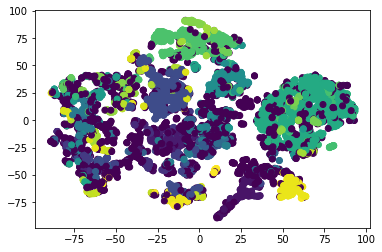

In [19]:
plt.scatter(data[0], data[1], c=data.labels)

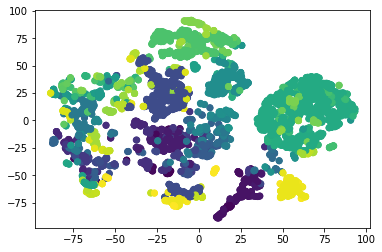

In [20]:
plt.scatter(data[data.labels != -1][0], data[data.labels != -1][1], c=data[data.labels != -1].labels)

In [21]:
# очень недобные названия
col_names = dict()
for col in data.columns:
    col_names[col] = str(col)
data = data.rename(columns=col_names)

In [22]:
# переклеим исходные ярлыки из бест_модэл на исходный датафрэйм

In [23]:
df['labels'] = model.labels_

In [24]:
groups = dict()
# not_eligible_cols = ['response','pref_le', 'labels']
labels = list(df.labels.unique()) 
labels.append('global')
for label in labels:
    groups_int = dict()
    for col in df.columns:
        if label != 'global':
            groups_int[col] = df[df.labels == label][col].mean()
                              
        else:
            
            groups_int[col] = df[col].mean()
            
    groups[label] = groups_int

In [25]:
df_clusters = pd.DataFrame.from_dict(groups)

In [26]:
cluster_labels = list(df_clusters.columns)

# Задание 4

Интерпретируйте результаты кластеризации: объясните, чем схожи электростанции в каждом кластере и чем аномальные электростанции отличаются от остальных. 

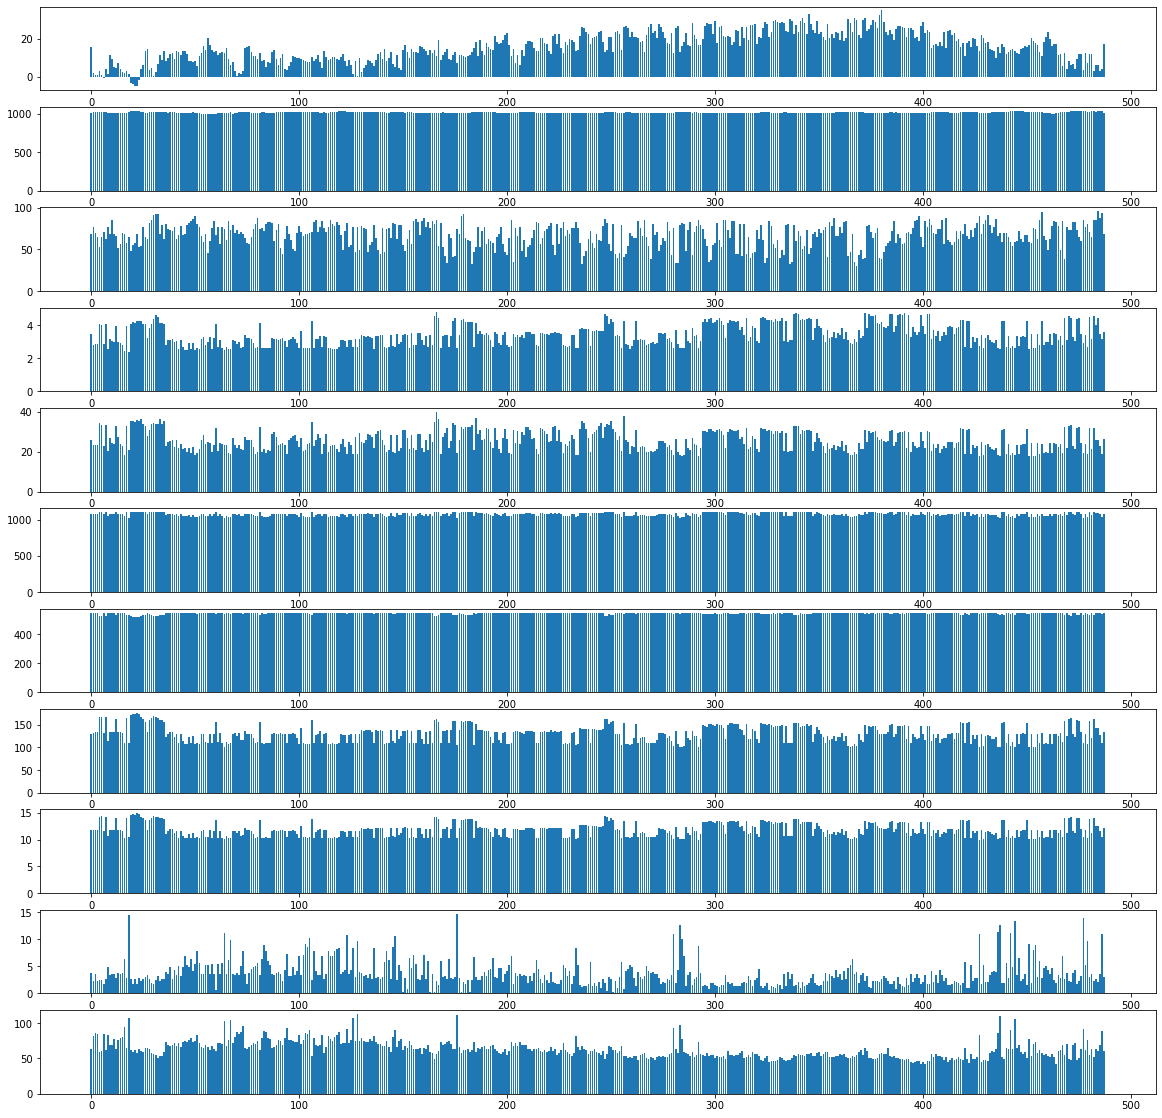

In [27]:
ax = plt.subplots(len(df_clusters.index)-1, 1, figsize=(20,20), )[1]
counter = 0
for ind in df_clusters.index:
    if ind == 'labels':
        continue
    y = list(df_clusters.loc[[ind]].T[ind])
#     x = list(range(len(list(df_clusters.loc[[ind]].T[ind]))))
    x = list(range(len(df_clusters.columns)))
    ax[counter].bar(x,  y)
    
    
    counter += 1

In [28]:
biggest_diff_dict = dict()
biggest_diff_list = []
biggest_diff_cluster_list = []
counter = 0
for ind in df_clusters.index:
    biggest_diff_list = sorted(abs(df_clusters.drop('global', axis=1).loc[ind]))[-3:]
    biggest_diff_cluster_list = []
    for col in df_clusters.columns:
        if col == 'global':
            continue
        if df_clusters.loc[ind, col] in biggest_diff_list:
            if len(biggest_diff_cluster_list) == 3:
                continue
            biggest_diff_cluster_list.append(col)
    biggest_diff_dict[ind] = biggest_diff_cluster_list
# biggest_diff_dict
        
        

In [29]:
df_clusters['biggest_difference'] = df_clusters.index
df_clusters['biggest_difference'] = df_clusters['biggest_difference'].apply(lambda x: biggest_diff_dict[x])

In [30]:
df_clusters_reserve = df_clusters.copy()

In [31]:
feature_names_list = ['AT — температура окружающей среды.',
'AP — давление окружающей среды.',
'AH — влажность окружающей среды.',
'AFDP — перепад давления на воздушном фильтре.',
'GTEP — давление на выходе из газовой турбины.',
'TIT — температура на входе в турбину.',
'TAT — температура на выходе из турбины.',
'TEY — энергоотдача турбины.',
'CDP — давление нагнетания компрессора.',
'CO — выбросы угарного газа.',
'NOX — выбросы оксидов азота.',
]

feature_names_dict = dict()
for feat in feature_names_list:
    feature_names_dict[feat.split(' — ')[0].lower()] = feat.split(' — ')[1]
    
    

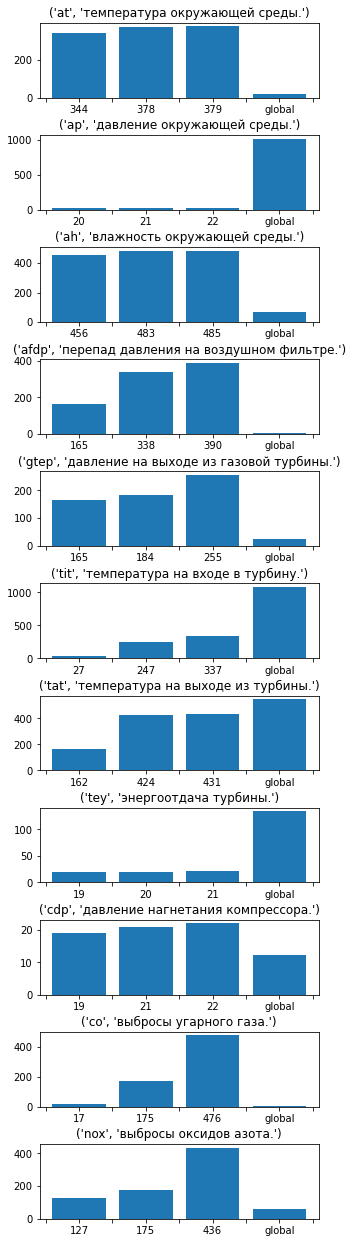

In [32]:
ax = plt.subplots(11, 1, figsize=(5,22), )[1]
plt.subplots_adjust(hspace=0.5, wspace=0.3)
counter = 0
for ind in df_clusters.index:
    if ind == 'labels':
        continue
    y = [ 
        df_clusters.loc[ind , 'biggest_difference'][0],
        df_clusters.loc[ind , 'biggest_difference'][1],
        df_clusters.loc[ind , 'biggest_difference'][2],
        df_clusters.loc[ind , 'global'],
    ]
    x = list(range(4))
    
    names = [
        ' ',
        ' ',
        df_clusters.loc[ind , 'biggest_difference'][0],
        ' ',
        df_clusters.loc[ind , 'biggest_difference'][1],
        ' ',
        df_clusters.loc[ind , 'biggest_difference'][2],
        ' ',
        'global',
    ]
    
    ax[counter].bar(x,y)
    ax[counter].set_xticklabels(names)
    ax[counter].set_title(f'{ind, feature_names_dict[ind]}')
#     plt.subplots_adjust(hspace=0.5, wspace=0.3)
    counter += 1

    


In [129]:
# из вышеприведенных столбиков людям, кто что то понимает в ветряных электростанциях, с, думаю, ненулевой вероятностью,  -->
# станет чуть более понятно, чтос ними делать:
# график показывает среднее по каждой фиче "в общем" и среднее по этой фиче в рамках определенного класса, с условием, 
# что на графике помещается три класса, максимально отличных по значениям от "глобального" среднего по этой фиче
# к примеру - классы 45 и 44 выбрасывают гораздо больше угарного газа, а в классе 57 очень сильно скачет 
# давление в воздушном фильтре, что бы это ни значило...:)

**Как отправить работу на проверку**

Скачайте файл с работой в материалах, откройте его через Jupyter Notebook и выполните задания. Сохраните изменения при помощи опции Save and Checkpoint на вкладке меню File или кнопки Save and Checkpoint на панели инструментов. Отправьте через форму ниже итоговый файл Jupyter Notebook (в формате .ipynb) или ссылку на него.
